In [4]:
#Importing essential libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn


In [5]:
# reading the train data
train = pd.read_csv("train.csv")
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
#Let's check for the missing values

train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

From the dataset, it is evident that the variables Item_Weight and Outlet_Size contains missing values in them.
It is important to treat the missing values before we do further analysis. 
Item_Weight is a continuous variable and we can impute the missing values by mean/median.
Outlet_Size is a categorical variable and we will impute the missing values by mode.

In [7]:
#Imputing the missing values by median for the variable Item_Weight

train.Item_Weight.fillna(train.Item_Weight.median(),inplace=True)

In [8]:
#Imputing the missing values in the Outlet_Size by replacing them with mode

train.Outlet_Size.fillna(train.Outlet_Size.mode()[0],inplace=True)

Any machine learning model build using scikit-learn cannot work with categorical variables, and I will use one-hot encoding to convert the categorical variables.

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. (https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)

The variables that needs to be converted are 

Item_Fat_Content
Item_Type, Outlet_Identifier
Outlet_Size, Outlet_Location_Type, and
Outlet_Type

In [22]:
!pip3 install category_encoders

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
pip install --upgrade category_encoders

  Using cached category_encoders-2.2.2-py2.py3-none-any.whl (80 kB)
You should consider upgrading via the '/Users/smitakshigupta/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import category_encoders as ce

In [24]:
# create an object of the OneHotEncoder
OHE = ce.OneHotEncoder(cols=['Item_Fat_Content',
                             'Item_Type',
                             'Outlet_Identifier',
                             'Outlet_Size',
                             'Outlet_Location_Type',
                             'Outlet_Type'],use_cat_names=True)
# encode the categorical variables
train_data = OHE.fit_transform(train)

After the treatment of missing values and categorical variables, we will go to the continuous variables. The continuous variables might have different scales and so we will normalize the dataset so that they are all in the same scale. We will use StandardScaler to normalize the data


In [25]:
from sklearn.preprocessing import StandardScaler
# creating an object of the StandardScaler
scaler = StandardScaler()
# fiting with the Item_MRP
scaler.fit(np.array(train_data.Item_MRP).reshape(-1,1))
# transforming the data
train_data.Item_MRP = scaler.transform(np.array(train_data.Item_MRP).reshape(-1,1))

In [28]:
#Building the model 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# separate the independent and target variable 
train_X = train_data.drop(columns=['Item_Identifier','Item_Outlet_Sales'])
train_Y = train_data['Item_Outlet_Sales']

# randomly split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.25,random_state=0)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((6392, 45), (2131, 45), (6392,), (2131,))

In [29]:
#The first model that we will run is Linear Regression

# create an object of the LinearRegression Model
model_LR = LinearRegression()

# fit the model with the training data
model_LR.fit(train_x, train_y)

# predict the target on train and test data 
predict_train = model_LR.predict(train_x)
predict_test  = model_LR.predict(test_x)

# Root Mean Squared Error on train and test date
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))

RMSE on train data:  1120.4149251582821
RMSE on test data:  1148.8331731264964


In [30]:
# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))

RMSE on train data:  899.1215504892718
RMSE on test data:  1114.9447240192771


After the preprocessing and encoding steps, we had a total of 45 features and not all of these may be useful in forecasting the sales. Alternatively we can select the top 5 or top 7 features, which had a major contribution in forecasting sales values.
If the model performance is similar in both the cases, that is – by using 45 features and by using 5-7 features, then we should use only the top 7 features, in order to keep the model more simple and efficient.

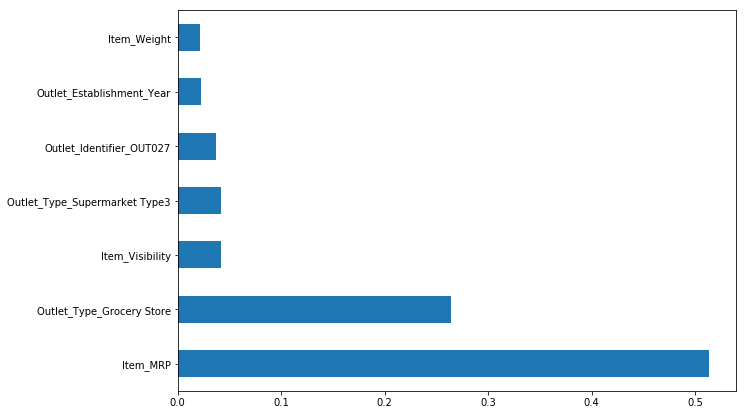

In [33]:
#Feature Engineering
# plot the 7 most important features

plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR.feature_importances_, index = train_x.columns)
feat_importances.nlargest(7).plot(kind='barh');

In [34]:
# training data with 7 most important features
train_x_if = train_x[['Item_MRP', 
                    'Outlet_Type_Grocery Store',
                    'Item_Visibility',
                    'Outlet_Type_Supermarket Type3',
                    'Outlet_Identifier_OUT027',
                    'Outlet_Establishment_Year',
                    'Item_Weight']]

# test data with 7 most important features
test_x_if = test_x[['Item_MRP', 
                    'Outlet_Type_Grocery Store',
                    'Item_Visibility',
                    'Outlet_Type_Supermarket Type3',
                    'Outlet_Identifier_OUT027',
                    'Outlet_Establishment_Year',
                    'Item_Weight']]

# create an object of the RandfomForestRegressor Model
model_RFR_with_if = RandomForestRegressor(max_depth=10,random_state=2)

# fit the model with the training data
model_RFR_with_if.fit(train_x_if, train_y)

# predict the target on the training and test data
predict_train_with_if = model_RFR_with_if.predict(train_x_if)
predict_test_with_if = model_RFR_with_if.predict(test_x_if)

# Root Mean Squared Error on the train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train_with_if)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test_with_if)**(0.5))

RMSE on train data:  899.9250381276628
RMSE on test data:  1117.4802283772383


In [35]:
#Testing the model with test data

test = pd.read_csv("test.csv")
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Before prediction on the test data, some pre-processing steps need to be done to get results. 

At first, we will check the categorical variables 
    
    
